In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torch
#import bcolz
import time
from utils import *
cwd = os.getcwd()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

prep1 = transforms.Compose([
            #transforms.RandomSizedCrop(512),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])


data_dir = 'Samples/'

class Dataset():
    __xs = []
    __ys = []

    def __init__(self, path, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        with open(folder_dataset + "data.txt") as f:
            for line in f:
                # Image path
                self.__xs.append(path + line.split()[0])        
                # Steering wheel label
                self.__ys.append(np.float32(line.split()[1]))

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        #img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = torch.from_numpy(np.asarray(img))
        label = torch.from_numpy(np.asarray(self.__ys[index]).reshape([1,1]))
        return img, label

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)


transformer = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,),(1.0,))])


train = torchvision.datasets.ImageFolder(cwd + '/Samples2/train',transform=transformer)
train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=48,
                                          shuffle=False,
                                          num_workers=8)

test = torchvision.datasets.ImageFolder(cwd + '/Samples2/test',transform=transformer)
test_loader = torch.utils.data.DataLoader(test,
                                          batch_size=48,
                                          shuffle=False,
                                          num_workers=8)    

use_gpu = torch.cuda.is_available()


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_conv = torchvision.models.resnet50(pretrained=True)

#model_conv = models.alexnet(pretrained=True)
#model_conv = models.squeezenet1_0(pretrained=True)
#model_conv = models.vgg16(pretrained=True)
#model_conv = models.densenet161(pretrained=True)
#model_conv = models.inception_v3(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
print(num_ftrs)
model_conv.fc = nn.Linear(num_ftrs* 100, 1024)
model_conv.fc2 = nn.Linear(1024, 5)
model= model_conv.to(device)
#print(model)
torch.cuda.is_available()
torch.cuda.set_device(1)
torch.backends.cudnn.benchmark=True
torch.backends.cudnn.fastest = True


optimizer = optim.Adam(model.parameters(), lr=0.00001)

criterion = nn.CrossEntropyLoss()
train_loss = []
train_f1 = []
test_loss = []
test_f1 = []
for epoch in range(20):
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    image = 0
    count = 0
    batch = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(train_loader):
        if x.shape[0] != 48:
            break
        for i in range(x.shape[0]):
            if count == 0:
                image = x[i,2:,:,:]
                count += 1
                continue
            elif count == 1:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count += 1
                continue
            else:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count = 0
            if i == 2:
                batch = image.reshape((-1,3,512,512))
            else:
                batch = torch.cat((batch, image.reshape((1,3,512,512))), dim=0)
                #print(batch.shape)
        tar = []
        for i in range(target.shape[0]):
            if i % 3 == 0:
                tar.append(target[i].item())
        target = torch.LongTensor(tar)
        x = batch.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, target.cuda())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
        correct_cnt+= (pred_label == target.cuda()).sum().item()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        for indx in range(16):
            
            if target[indx].item() > 0.5:
                if pred_label[indx].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred_label[indx].item() > 0.5:
                    FP += 1

            total_cnt += 1
                    
        if TP == 0 and FP == 0:
            FP = 1
        if TP == 0 and FN == 0:
            FN = 1
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        if precision == 0 and recall == 0:
            recall = 1
        f1 = 2*((precision*recall)/(precision+recall))
    train_loss.append(ave_loss)
    train_f1.append(f1)
    print('==>>> epoch: {}, train loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    image = 0
    count = 0
    batch = 0
    TP = 0 #true positive
    FP = 0 #false positive
    FN = 0 #false negative
    for batch_idx, (x, target) in enumerate(test_loader):
        if x.shape[0] != 48:
            break
        for i in range(x.shape[0]):
            if count == 0:
                image = x[i,2:,:,:]
                count += 1
                continue
            elif count == 1:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count += 1
                continue
            else:
                image = torch.cat((image, x[i,2:,:,:]), dim=0)
                count = 0
            if i == 2:
                batch = image.reshape((-1,3,512,512))
            else:
                batch = torch.cat((batch, image.reshape((1,3,512,512))), dim=0)
                #print(batch.shape)
        x = batch.cuda()
        
        tar = []
        for i in range(target.shape[0]):
            if i % 3 == 0:
                tar.append(target[i].item())
        target = torch.LongTensor(tar)
        #print(target.shape)
        out = model(x)
        #print(out.shape)
        loss = criterion(out, target.cuda())
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.shape[0]
#         print(target.data)
        correct_cnt += (pred_label == target.cuda()).sum().item()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        for indx in range(16):
            
            if target[indx].item() > 0.5:
                if pred_label[indx].item() > 0.5:
                    TP += 1
                else:
                    FN += 1
            else:
                if pred_label[indx].item() > 0.5:
                    FP += 1

            total_cnt += 1
                    
        if TP == 0 and FP == 0:
            FP = 1
        if TP == 0 and FN == 0:
            FN = 1
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        if precision == 0 and recall == 0:
            recall = 1
        f1 = 2*((precision*recall)/(precision+recall))
    test_loss.append(ave_loss)
    test_f1.append(f1)
    print('==>>> epoch: {}, test loss: {:.6f}, acc: {:.3f}, f1:{:.3f}'.format(
                epoch, ave_loss, correct_cnt*1.0/total_cnt, f1))

2048
==>>> epoch: 0, train loss: 0.279388, acc: 0.411, f1:0.963
==>>> epoch: 0, test loss: 9.190199, acc: 0.114, f1:0.711
==>>> epoch: 1, train loss: 0.368205, acc: 0.357, f1:0.886
==>>> epoch: 1, test loss: 7.905378, acc: 0.114, f1:0.711
==>>> epoch: 2, train loss: 0.304794, acc: 0.362, f1:0.896
==>>> epoch: 2, test loss: 7.633440, acc: 0.114, f1:0.711
==>>> epoch: 3, train loss: 0.278067, acc: 0.362, f1:0.899
==>>> epoch: 3, test loss: 7.576861, acc: 0.114, f1:0.711


Process Process-72:
Process Process-70:
Process Process-69:
Process Process-71:
Process Process-68:
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-66:
Process Process-67:
Process Process-65:
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHE

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

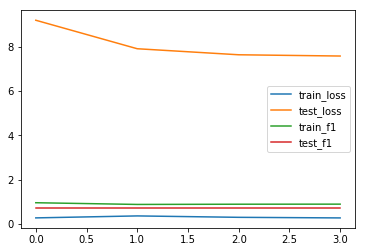

In [2]:
import matplotlib.pyplot as plt
plt.plot(train_loss,label='train_loss')
plt.plot(test_loss,label='test_loss')
plt.plot(train_f1,label='train_f1')
plt.plot(test_f1,label='test_f1')
plt.legend()
plt.show()